In [68]:
import random
import matplotlib.pyplot as plt
import numpy as np

num_villes = 5000
num_clients = num_villes - 1  # Exclure le dépôt

def generate_weighted_adjacency_matrix(n):
    adjacency_matrix = np.random.rand(n, n)  # Générer une matrice aléatoire entre 0 et 1
    adjacency_matrix *= 100  # Multiplier par une valeur maximale pour représenter les poids des distances
    adjacency_matrix = np.round(adjacency_matrix).astype(int)  # Arrondir les valeurs et les convertir en entiers
    np.fill_diagonal(adjacency_matrix, 0)  # Remplir les diagonales avec des zéros pour représenter les distances de la ville à elle-même
    return adjacency_matrix

matrice = generate_weighted_adjacency_matrix(num_villes)
print(matrice)


[[ 0 70 46 ... 32  1 69]
 [10  0 41 ... 35 14 70]
 [40 46  0 ... 99 57 39]
 ...
 [61 80  4 ...  0 43 92]
 [ 4 85 16 ... 59  0 57]
 [18 95 15 ... 10 89  0]]


In [76]:
import random
import numpy as np
from numpy.random import choice as np_choice

# Évaluer la qualité des solutions
def calculer_distance_total(solution, matrice):
    distances = matrice[solution[:-1], solution[1:]]
    return np.sum(distances)

def maj_pheromone(matrice_pheromone, routes, distances):
    evaporation = 0.5
    pheromone_depose = 100

    # Évaporation des phéromones   
    matrice_pheromone *= (1 - evaporation)

    # Dépôt de phéromones sur les meilleures routes
    for route, distance in zip(routes, distances):
        pheromones = Q / distance
        matrice_pheromone[route[:-1], route[1:]] += pheromones

def selectionner_ville(matrice_pheromone, current_ville, ville_non_visitee, alpha, beta):
    pheromone = matrice_pheromone[current_ville, ville_non_visitee]
    distance = matrice[current_ville, ville_non_visitee]
    proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)

    proba[distance == 0] = 0  # Gérer les distances nulles
    
    total_proba = np.sum(proba)
    if total_proba == 0:
        proba = np.ones(len(proba)) / len(proba)
    else:
        proba /= total_proba

    proba = np.maximum(proba, 0)

    next_ville_index = np_choice(len(ville_non_visitee), p=proba)
    next_ville = ville_non_visitee[next_ville_index]

    return next_ville


def vrp(matrice, num_fourmis, num_iterations, alpha, beta):
    num_ville = len(matrice)
    matrice_pheromone = np.ones((num_ville, num_ville))  # Matrice des phéromones
    best_route = None
    best_distance = float('inf')

    for i in range(num_iterations):
        routes = []
        distances = []

        for j in range(num_fourmis):
            route = [0]  # Dépôt initial
            ville_non_visitees = np.arange(1, num_ville)  # Villes non visitées
            while ville_non_visitees.size > 0:
                current_ville = route[-1]
                next_ville = selectionner_ville(matrice_pheromone, current_ville, ville_non_visitees, alpha, beta)
                route.append(next_ville)
                ville_non_visitees = np.delete(ville_non_visitees, np.where(ville_non_visitees == next_ville))

            route.append(0)  # Retour au dépôt

            if ville_non_visitees.size == 0 and route[-1] == 0:
                distance = calculer_distance_total(route, matrice)
                routes.append(route)
                distances.append(distance)

                if distance < best_distance:
                    best_route = route
                    best_distance = distance

        maj_pheromone(matrice_pheromone, routes, distances)

    return best_route, best_distance


# On répartit entre le nombre de camions
def repartir_routes_optimal(route, num_camions):
    villes = route[1:-1]  # Liste des villes à répartir (excluant le dépôt)
    num_villes = len(villes)

    # Calcul de la distance totale de la route
    distance_totale = calculer_distance_total(route, matrice)

    # Calcul de la distance moyenne par camion
    distance_moyenne = distance_totale / num_camions

    camions_routes = []
    longueurs_routes = []

    camion_route = [0]  # Dépôt initial
    longueur_route = 0

    for i in range(num_villes):
        ville = villes[i]
        ville_suivante = villes[i + 1] if i < num_villes - 1 else 0  # Prochaine ville ou retour au dépôt

        # Ajout de la ville à la route actuelle
        camion_route.append(ville)
        longueur_route += matrice[ville][ville_suivante]

        # Si la longueur de la route actuelle dépasse la distance moyenne, on la termine et on commence une nouvelle route
        if longueur_route > distance_moyenne:
            camion_route.append(0)  # Retour au dépôt
            camions_routes.append(camion_route)
            longueurs_routes.append(longueur_route)

            camion_route = [0]  # Nouvelle route avec le dépôt initial
            longueur_route = 0

    # Ajout de la dernière route incomplète
    camion_route.append(0)  # Retour au dépôt
    camions_routes.append(camion_route)
    longueurs_routes.append(longueur_route)

    return camions_routes, longueurs_routes

# Paramètres de l'ACO
num_fourmis = 4
num_iterations = 10
alpha = 1.0  # Influence de la phéromone
beta = 5.0  # Influence de la visibilité
rho = 0.5  # Taux d'évaporation de la phéromone
Q = 100  # Quantité de phéromone déposée par les fourmis
num_camions = 3  # Quantité de camions

best_route, best_distance = vrp(matrice, num_fourmis, num_iterations, alpha, beta)
camions_routes, longueurs_routes = repartir_routes_optimal(best_route, num_camions)

print("|-----------------Meilleur Global-----------------|")
print("Meilleure route:", best_route)
print("Distance totale:", best_distance)
print("|---------------Meilleur par camion---------------|")

# Affichage des routes assignées à chaque camion et de la longueur totale de chaque route
for i, route in enumerate(camions_routes):
    print(f"|------------------------{i+1}-----------------------|")
    print(f"Camion {i+1} - Route : {route} ")
    print(f"Distance totale : {longueurs_routes[i]}")
    

C:\Users\Theo\AppData\Local\Temp\ipykernel_9360\2278144908.py:25: RuntimeWarning: divide by zero encountered in divide
  proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)


|-----------------Meilleur Global-----------------|
Meilleure route: [0, 813, 1976, 11, 1439, 1899, 4567, 2014, 2927, 1659, 464, 698, 33, 3145, 516, 2202, 73, 2232, 4742, 2330, 2276, 2518, 1385, 4270, 3074, 3929, 2661, 2578, 1029, 2968, 362, 4861, 2669, 251, 2048, 2919, 4725, 3430, 1198, 668, 3773, 2447, 1583, 468, 1219, 933, 4853, 2513, 4870, 4409, 696, 2560, 3229, 4820, 1599, 4698, 4938, 2749, 3449, 1520, 1951, 3727, 2761, 4388, 2405, 4045, 4469, 4517, 3100, 3044, 4722, 530, 1595, 4830, 338, 3426, 3054, 1818, 1910, 2658, 1440, 2662, 1982, 1559, 2534, 2547, 867, 4902, 176, 799, 4180, 2621, 158, 3813, 3841, 60, 2612, 2186, 3304, 3485, 4360, 4931, 3844, 901, 3593, 1889, 3581, 2438, 3407, 968, 843, 2521, 474, 1003, 2865, 974, 3613, 4554, 480, 3968, 3306, 114, 2350, 3487, 2949, 1426, 1381, 2565, 1348, 394, 3798, 2810, 2441, 450, 3032, 1925, 1656, 3266, 1099, 3217, 3728, 3610, 1129, 1475, 4424, 456, 861, 751, 1445, 853, 2999, 1635, 2812, 3208, 3276, 2174, 3279, 3719, 4834, 3459, 1755, 4403

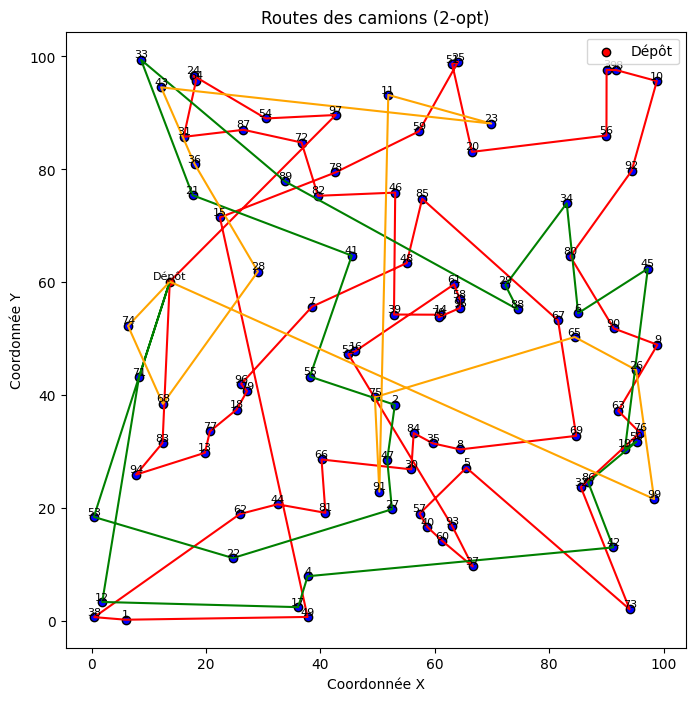

In [4]:
import random
import matplotlib.pyplot as plt

def generer_coordonnees(n, distance_min):
    coordonnees = []
    for _ in range(n):
        x = random.uniform(0, 1000)  # Coordonnée X aléatoire entre 0 et 100
        y = random.uniform(0, 1000)  # Coordonnée Y aléatoire entre 0 et 100
        coordonnees.append((x, y))

    # Ajuster les coordonnées pour respecter la distance minimale
    for i in range(n - 1):
        x1, y1 = coordonnees[i]
        x2, y2 = coordonnees[i + 1]
        distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        while distance < distance_min:
            x = random.uniform(0, 1000)
            y = random.uniform(0, 1000)
            coordonnees[i + 1] = (x, y)
            x2, y2 = coordonnees[i + 1]
            distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    return coordonnees


def calculer_distance(coordonnees, i, j):
    x1, y1 = coordonnees[i]
    x2, y2 = coordonnees[j]
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

def calculer_distance_total(coordonnees, route):
    distance = 0
    for i in range(len(route) - 1):
        distance += calculer_distance(coordonnees, route[i], route[i + 1])
    return distance

def opt_2(route):
    amelioration = True
    while amelioration:
        amelioration = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue
                nouvelle_route = route[:]
                nouvelle_route[i:j] = route[j - 1:i - 1:-1]
                if calculer_distance_total(coordonnees, nouvelle_route) < calculer_distance_total(coordonnees, route):
                    route = nouvelle_route
                    amelioration = True
        return route

def tracer_routes(coordonnees, camions_routes):
    plt.figure(figsize=(8, 8))

    # Tracer les villes
    for i, (x, y) in enumerate(coordonnees):
        if i == 0:
            plt.scatter(x, y, color='red', edgecolors='black', label='Dépôt')
            plt.text(x, y, 'Dépôt', ha='center', va='bottom', fontsize=8)
        else:
            plt.scatter(x, y, color='blue', edgecolors='black')
            plt.text(x, y, str(i), ha='center', va='bottom', fontsize=8)

    # Tracer les routes des camions
    colors = ['red', 'green', 'orange', 'purple', 'cyan', 'magenta']
    for i, route in enumerate(camions_routes):
        route_opt2 = opt_2(route)
        x_values = [coordonnees[ville][0] for ville in route_opt2]
        y_values = [coordonnees[ville][1] for ville in route_opt2]
        x_values.append(coordonnees[route_opt2[0]][0])  # Ajouter le point de départ à la fin pour fermer la boucle
        y_values.append(coordonnees[route_opt2[0]][1])
        plt.plot(x_values, y_values, color=colors[i % len(colors)])

    plt.title('Routes des camions (2-opt)')
    plt.xlabel('Coordonnée X')
    plt.ylabel('Coordonnée Y')
    plt.grid(False)
    plt.legend()
    plt.show()



coordonnees = generer_coordonnees(1000, 30)


# Tracer les routes des camions sur la carte en utilisant 2-opt pour réarranger les points
tracer_routes(coordonnees, camions_routes)
